In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tqdm
import random
import torch
import matplotlib.pyplot as plt

from utils.visualization import visualize_sample
from model.utils import create_vlm
from model.utils import VisualTextualTokenization
from data import get_dataset
from visual_tokenizer import get_visual_tokenizer
import json

In [5]:

from data import (
    ShareGPT4V,
    ImageNet,
    Cambrian
)


# dataset = ImageNet(root='/datasets01/imagenet_full_size/061417', split='val')

dataset = ShareGPT4V(
    root='/private/home/delong/workspace/data/ShareGPT4V',
    split='sharegpt4v_instruct_gpt4-vision_cap100k.json')


# dataset = ShareGPT4V(
#     root='/private/home/delong/workspace/data/ShareGPT4V',
#     split='share-captioner_coco_lcs_sam_1246k_1107.json')


Total samples: 102025, in sharegpt4v_instruct_gpt4-vision_cap100k.json split: 102025
After removing text-only samples: 102025


In [6]:
checkpoint = "runs/sharegpt4v/Phi-3-mini-128k-instruct/1129-1034-directsam_tiny_dsa_100ep@0_1(100t-768px)-in1k_mobilenetv3_all(768px)/runs/checkpoint-4870"
model, textual_tokenizer = create_vlm(
    checkpoint, 
    llm_class='phi'
    )

model = model.cuda().half().eval()

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Loded LLM from pretrained: "runs/sharegpt4v/Phi-3-mini-128k-instruct/1129-1034-directsam_tiny_dsa_100ep@0_1(100t-768px)-in1k_mobilenetv3_all(768px)/runs/checkpoint-4870"


In [7]:
image_resolution = 224
max_tokens = 4

# config = json.load(open('configs/visual_tokenizer/directsam/directsam_tiny_dsa_100ep@0.1.json'))
config = json.load(open('configs/visual_tokenizer/patch/patch_2_per_side_random.json'))


visual_tokenizer = get_visual_tokenizer(**config, image_resolution=image_resolution, max_tokens=max_tokens)

vl_tokenizer = VisualTextualTokenization(textual_tokenizer, visual_tokenizer)

In [14]:
n_samples = 10
loss = 0
for _ in tqdm.tqdm(range(n_samples)):
    sample = dataset[random.randint(0, len(dataset))]
    inputs = vl_tokenizer([sample], eval=True)

    mask_sum = inputs['masks'].sum(dim=(2, 3))[0]
    non_zero_masks = (mask_sum > 0).sum().item()
    print(f"Non-zero masks: {non_zero_masks}")


    with torch.no_grad():
        outputs = model(**inputs)
        loss += outputs['loss'].item()

print(f"Loss: {loss / n_samples}")

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 10%|█         | 1/10 [00:00<00:03,  2.47it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 20%|██        | 2/10 [00:00<00:03,  2.48it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 30%|███       | 3/10 [00:01<00:02,  2.86it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 40%|████      | 4/10 [00:01<00:02,  2.78it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 50%|█████     | 5/10 [00:01<00:01,  2.60it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 60%|██████    | 6/10 [00:02<00:01,  2.82it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 70%|███████   | 7/10 [00:02<00:01,  2.71it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 80%|████████  | 8/10 [00:02<00:00,  2.79it/s]

torch.Size([1, 4, 224, 224])
torch.Size([4])
Non-zero masks: 4


 80%|████████  | 8/10 [00:03<00:00,  2.46it/s]


KeyboardInterrupt: 

<|user|>
Can you elaborate on the elements of the picture provided?
<|image|><|endoftext|>
<|assistant|>


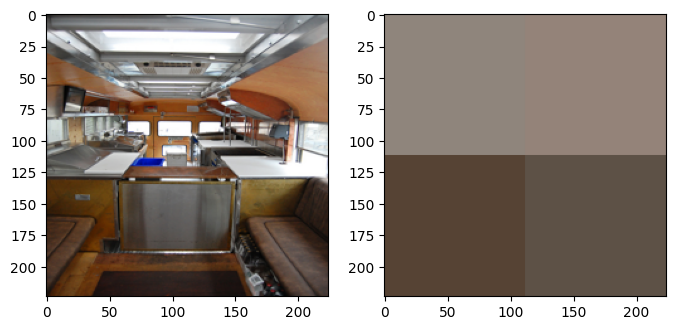

The image captures the serene ambiance of an empty food truck. The interior is immaculate, with clean counters and appliances ready for the next service. The walls and ceiling, constructed of sturdy metal, reflect the soft glow of two ceiling lights. The wooden floor adds a touch of warmth to the otherwise industrial space.

On the left side of the truck, a black cooktop stove waits patiently for its next culinary task, positioned next to a sink for easy cleanup. A comfortable bench provides a place to rest during quieter moments. On the right side, a refrigerator stands ready to preserve fresh ingredients, while a counter with a blue countertop offers ample space for food preparation. 

Adding a touch of homeliness, white curtains adorn two windows on the right side and one on the left, allowing natural light to filter into the space. A table draped with a white tablecloth sits on the right, perhaps serving as an additional workspace or dining area.

Overall, this food truck is a well

In [9]:
sample = dataset[random.randint(0, len(dataset))]

label = sample['text'].split('<|assistant|>')[1].strip().replace(textual_tokenizer.eos_token, '')
sample['text'] = sample['text'].split('<|assistant|>')[0] + '<|assistant|>'

inputs = vl_tokenizer([sample], eval=True)


inputs_embeds, labels = model.prepare_inputs_embeds(
    inputs['text'], inputs['image'], inputs['masks']
)

outputs = model.generate(
    inputs_embeds=inputs_embeds,
    do_sample=False,
    max_new_tokens=dataset.max_text_tokens,
    eos_token_id = textual_tokenizer.eos_token_id,
    pad_token_id = textual_tokenizer.pad_token_id,
)
prediction = textual_tokenizer.decode(outputs[0], skip_special_tokens=True)

visualize_sample(sample, inputs)
print(label)
print('-' * 80)
print(prediction)